In [48]:
from pytorch_forecasting.data.examples import get_stallion_data
import numpy as np
data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,...,-,-,-,8.532566,0,0,1,3.956461,2613.377501,103.805460
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,...,-,-,-,13.000635,5,0,1,-18.420681,1361.511918,0.549900
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,...,-,-,-,5.792496,9,0,1,6.700634,1225.306376,2041.909586
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,...,-,-,-,7.940950,14,0,1,5.757134,2613.377501,125.690220
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,...,-,-,-,8.981168,22,0,1,6.042417,1179.728165,1638.463500


In [30]:
import torch 
def find_device(debug=False) -> str:
    import torch
    # Check if CUDA (GPU support) is available
    if torch.cuda.is_available():
        device = torch.device("cuda")
    # If not, check for Metal Performance Shaders (MPS) for Apple Silicon
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    # Fallback to CPU if neither CUDA nor MPS is available
    else:
        device = torch.device("cpu")

    if debug:
        print(f"Using device: {device}")
    return device

device = find_device(debug=True)

Using device: mps


In [218]:
pred_horizon = 5
historical_horizon=25
batch_size=8
emsize = 64  # Embedding dimension
nhid = 64  # Dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # Number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # Number of heads in the multiheadattention models
dropout = 0.2  # Dropout value

In [219]:
data.iloc[1:3]['volume']

238      0.0000
237    812.9214
Name: volume, dtype: float64

In [220]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import NaNLabelEncoder  # Ensure you have this, or implement a custom version

class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, target="volume", 
                 historical_horizon=250,
                 prediction_horizon=1,
                 groups = [],
                 encoder_continuous_features=[], encoder_categorical_features=[],
                 decoder_continuous_features=[], decoder_categorical_features=[]):
        self.dataframe = dataframe.copy()
        self.target = target
        self.prediction_horizon = prediction_horizon
        self.historical_horizon = historical_horizon
        # Feature sets for encoder and decoder
        self.encoder_continuous_features = encoder_continuous_features
        self.encoder_categorical_features = encoder_categorical_features
        self.decoder_continuous_features = decoder_continuous_features
        self.decoder_categorical_features = decoder_categorical_features

        # Apply StandardScaler to continuous features
        self.scaler = StandardScaler()
        continuous_and_target_features = self.encoder_continuous_features + self.decoder_continuous_features + [self.target]
        self.dataframe[continuous_and_target_features] = \
            self.scaler.fit_transform(self.dataframe[continuous_and_target_features])

        # Apply NaNLabelEncoder to categorical features
        self.nan_label_encoder = NaNLabelEncoder()
        for feature in self.encoder_categorical_features + self.decoder_categorical_features:
            self.dataframe[feature] = self.nan_label_encoder.fit_transform(self.dataframe[feature])
        
        #self.grouped_data = self.dataframe.groupby(groups)
        # Group data and store as a list of (group_key, group_dataframe) tuples
        self.grouped_data = [(group_key, group_df) for group_key, group_df in self.dataframe.groupby(groups)]


    def __len__(self):
        # Adjust length to account for prediction horizon
        #return sum(len(group) - self.prediction_horizon for _, group in self.grouped_data)
        return len(self.grouped_data)

    def __getitem__(self, idx):
        # Find which group and index within that group this global index corresponds to
        # Select a random group
        group_key, group_df = self.grouped_data[idx]

        # Prepare encoder features
        #encoder_features = [row[feature] for feature in self.encoder_continuous_features]
        encoder_features = group_df[self.encoder_continuous_features + self.encoder_categorical_features].values.tolist()
        #encoder_features += [row[feature] for feature in self.encoder_categorical_features]

        # Prepare decoder features
        decoder_features = group_df[self.decoder_continuous_features + self.decoder_categorical_features + [self.target]].values.tolist()
        #decoder_features = [row[feature] for feature in self.decoder_continuous_features]
        #decoder_features += [row[feature] for feature in self.decoder_categorical_features]
        #decoder_features += [row[self.target]]
        # Adjust target to be 'prediction_horizon' timesteps in the future
        # Convert to tensors
        row_idx = torch.randint(low=historical_horizon, high=len(group_df)-self.prediction_horizon, size=(1,1))[0]
                
        y_value = group_df[self.target].values
        encoder_tensor = torch.tensor(encoder_features, dtype=torch.float32, device=device)[row_idx-self.historical_horizon:row_idx]
        decoder_tensor = torch.tensor(decoder_features, dtype=torch.float32, device=device)[row_idx-self.historical_horizon:row_idx]
        y_tensor = torch.tensor(y_value.tolist(), dtype=torch.float32, device=device)[row_idx:row_idx+self.prediction_horizon]

        return encoder_tensor, decoder_tensor, y_tensor


known_categorical=['agency', 'sku']
unknown_categorical = []
unkown_continuous = [
"log_volume",
"industry_volume",
"soda_volume",
"avg_max_temp",
"avg_volume_by_agency",
"avg_volume_by_sku"]
known_continuous = ["time_idx", "price_regular", "discount_in_percent"]
target = "volume"
# Create the dataset
dataset = TimeSeriesDataset(data, 
                            target="volume",
                            groups=['agency', 'sku'],
                            prediction_horizon=pred_horizon,
                            historical_horizon=historical_horizon,
                            encoder_continuous_features=known_continuous,
                            encoder_categorical_features=known_categorical,
                            decoder_continuous_features=unkown_continuous,
                            decoder_categorical_features=unknown_categorical
                            )

def custom_collate_fn(batch):
    # 'batch' is a list of tuples returned by TimeSeriesDataset.__getitem__
    encoder_tensors = [item[0] for item in batch]
    decoder_tensors = [item[1] for item in batch]
    y_tensors = [item[2] for item in batch]
    # You can handle group keys here if needed
    #group_keys = [item[3] for item in batch]

    # Combine the individual tensors into a batch
    encoder_batch = torch.stack(encoder_tensors)
    decoder_batch = torch.stack(decoder_tensors)
    y_batch = torch.stack(y_tensors)

    return encoder_batch, decoder_batch, y_batch  # Include group_keys in return if needed

# Create DataLoader with custom collate function
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)


In [211]:
for encoder_inputs, decoder_inputs, targets in data_loader:
    # Your training logic here
    print(f"--- Encoder Input --- {encoder_inputs.shape}")
    print(encoder_inputs)
    print(f"--- Decoder Input ---- {decoder_inputs.shape}")
    print(decoder_inputs)
    print(f"--- Target --- {targets.shape}")
    print(targets)
    break

--- Encoder Input --- torch.Size([4, 25, 5])
tensor([[[-5.4856e-01,  8.8427e-01,  1.5785e+00,  2.6000e+01,  6.1000e+01],
         [-4.9082e-01,  8.9779e-01,  2.8372e-02,  2.6000e+01,  6.1000e+01],
         [-4.3307e-01,  9.0258e-01,  2.3169e-01,  2.6000e+01,  6.1000e+01],
         [-3.7533e-01,  9.0252e-01, -1.1803e-01,  2.6000e+01,  6.1000e+01],
         [-3.1759e-01,  9.0006e-01,  5.6055e-01,  2.6000e+01,  6.1000e+01],
         [-2.5984e-01,  9.0132e-01,  3.9400e-02,  2.6000e+01,  6.1000e+01],
         [-2.0210e-01,  8.9762e-01, -6.2693e-02,  2.6000e+01,  6.1000e+01],
         [-1.4436e-01,  8.9835e-01,  7.8916e-02,  2.6000e+01,  6.1000e+01],
         [-8.6615e-02,  8.9830e-01, -3.3347e-01,  2.6000e+01,  6.1000e+01],
         [-2.8872e-02,  9.7058e-01,  6.9248e-01,  2.6000e+01,  6.1000e+01],
         [ 2.8872e-02,  1.0789e+00,  3.6313e-01,  2.6000e+01,  6.1000e+01],
         [ 8.6615e-02,  1.1273e+00,  2.8041e-01,  2.6000e+01,  6.1000e+01],
         [ 1.4436e-01,  1.1572e+00,  1.1282

In [223]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

class TransformerClassifier(nn.Module):
    def __init__(self, enc_feature_size, dec_feature_size, embd_size, nhead, nhid, nlayers, pred_horizon, dropout=0.5):
        super(TransformerClassifier, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(embd_size, dropout)
        self.pos_decoder = PositionalEncoding(embd_size, dropout)

        encoder_layers = TransformerEncoderLayer(embd_size, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        decoder_layers = TransformerDecoderLayer(embd_size, nhead, nhid, dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)

        self.enc_linear = nn.Linear(enc_feature_size, embd_size)  # For encoder input features
        self.dec_linear = nn.Linear(dec_feature_size, embd_size)  # For decoder input features
        self.ln_f = nn.LayerNorm(embd_size)
        self.final_linear = nn.Linear(embd_size, pred_horizon)  # Adjust for the dimension of the target variable
        self.emb_size = embd_size
        self.init_weights()

    def generate_square_subsequent_mask(self, sz: int):
        """Generate a square mask for the sequence. The masked positions are filled with float('-inf').
           Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def init_weights(self):
        initrange = 0.1
        self.enc_linear.weight.data.uniform_(-initrange, initrange)
        self.enc_linear.bias.data.zero_()
        self.dec_linear.weight.data.uniform_(-initrange, initrange)
        self.dec_linear.bias.data.zero_()
        self.final_linear.bias.data.zero_()
        self.final_linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, enc_input, dec_input):
        enc_input = self.enc_linear(enc_input) * math.sqrt(self.emb_size)
        enc_input = self.pos_encoder(enc_input)
        memory = self.transformer_encoder(enc_input)
        dec_input = self.dec_linear(dec_input) * math.sqrt(self.emb_size)
        dec_input = self.pos_decoder(dec_input)
        # Create a causal mask for the decoder input
        tgt_causal_mask = self.generate_square_subsequent_mask(dec_input.size(0))
        # Decoder can only see past values
        output = self.transformer_decoder(dec_input, memory, tgt_mask=tgt_causal_mask)
        output = self.ln_f(output)
        # Use only the last timestep's output
        output = output[:, -1, :]
        output = self.final_linear(output)
        return output

# Example of a PositionalEncoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def train(model, data_loader, criterion, optimizer, epochs, pred_horizon):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for encoder_tensor, decoder_tensor, y_tensor in data_loader:
            optimizer.zero_grad()

            # Forward pass through the model
            output = model(encoder_tensor, decoder_tensor)

            # Reshape output and y_tensor to match the criterion requirements
            # Assuming output is of shape [batch_size, pred_horizon] and y_tensor is the same
            output_flat = output.view(-1, pred_horizon)
            y_tensor_flat = y_tensor.view(-1, pred_horizon)

            # Calculate loss
            loss = criterion(output_flat, y_tensor_flat)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Calculate average loss per batch
        average_loss = total_loss / len(data_loader)
        print(f'Epoch {epoch}, Loss {average_loss}')

# Example usage
enc_feature_size = len(dataset.encoder_categorical_features) + len(dataset.encoder_continuous_features)  # Number of features for encoder
dec_feature_size = len(dataset.decoder_categorical_features) + len(dataset.decoder_continuous_features) + 1 # Number of features for decoder


model = TransformerClassifier(enc_feature_size, dec_feature_size, emsize, nhead, nhid, nlayers, pred_horizon, dropout)
model.to(device)
# Create your data_loader, criterion, optimizer here
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

train(model, data_loader, criterion, optimizer, epochs=20, pred_horizon=pred_horizon)


/Users/mehditantaoui/Documents/Challenges/TemporalFusionTransformerClassifier/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, Loss 0.9954584676095031
Epoch 1, Loss 0.8397866978564046
Epoch 2, Loss 0.7284902837127447
Epoch 3, Loss 0.5792266597801988
Epoch 4, Loss 0.5373708326369524
Epoch 5, Loss 0.4305030381815
Epoch 6, Loss 0.44505328574979847
Epoch 7, Loss 0.36183067758313636
Epoch 8, Loss 0.33140563897111197


IndexError: index 3 is out of bounds for axis 0 with size 3

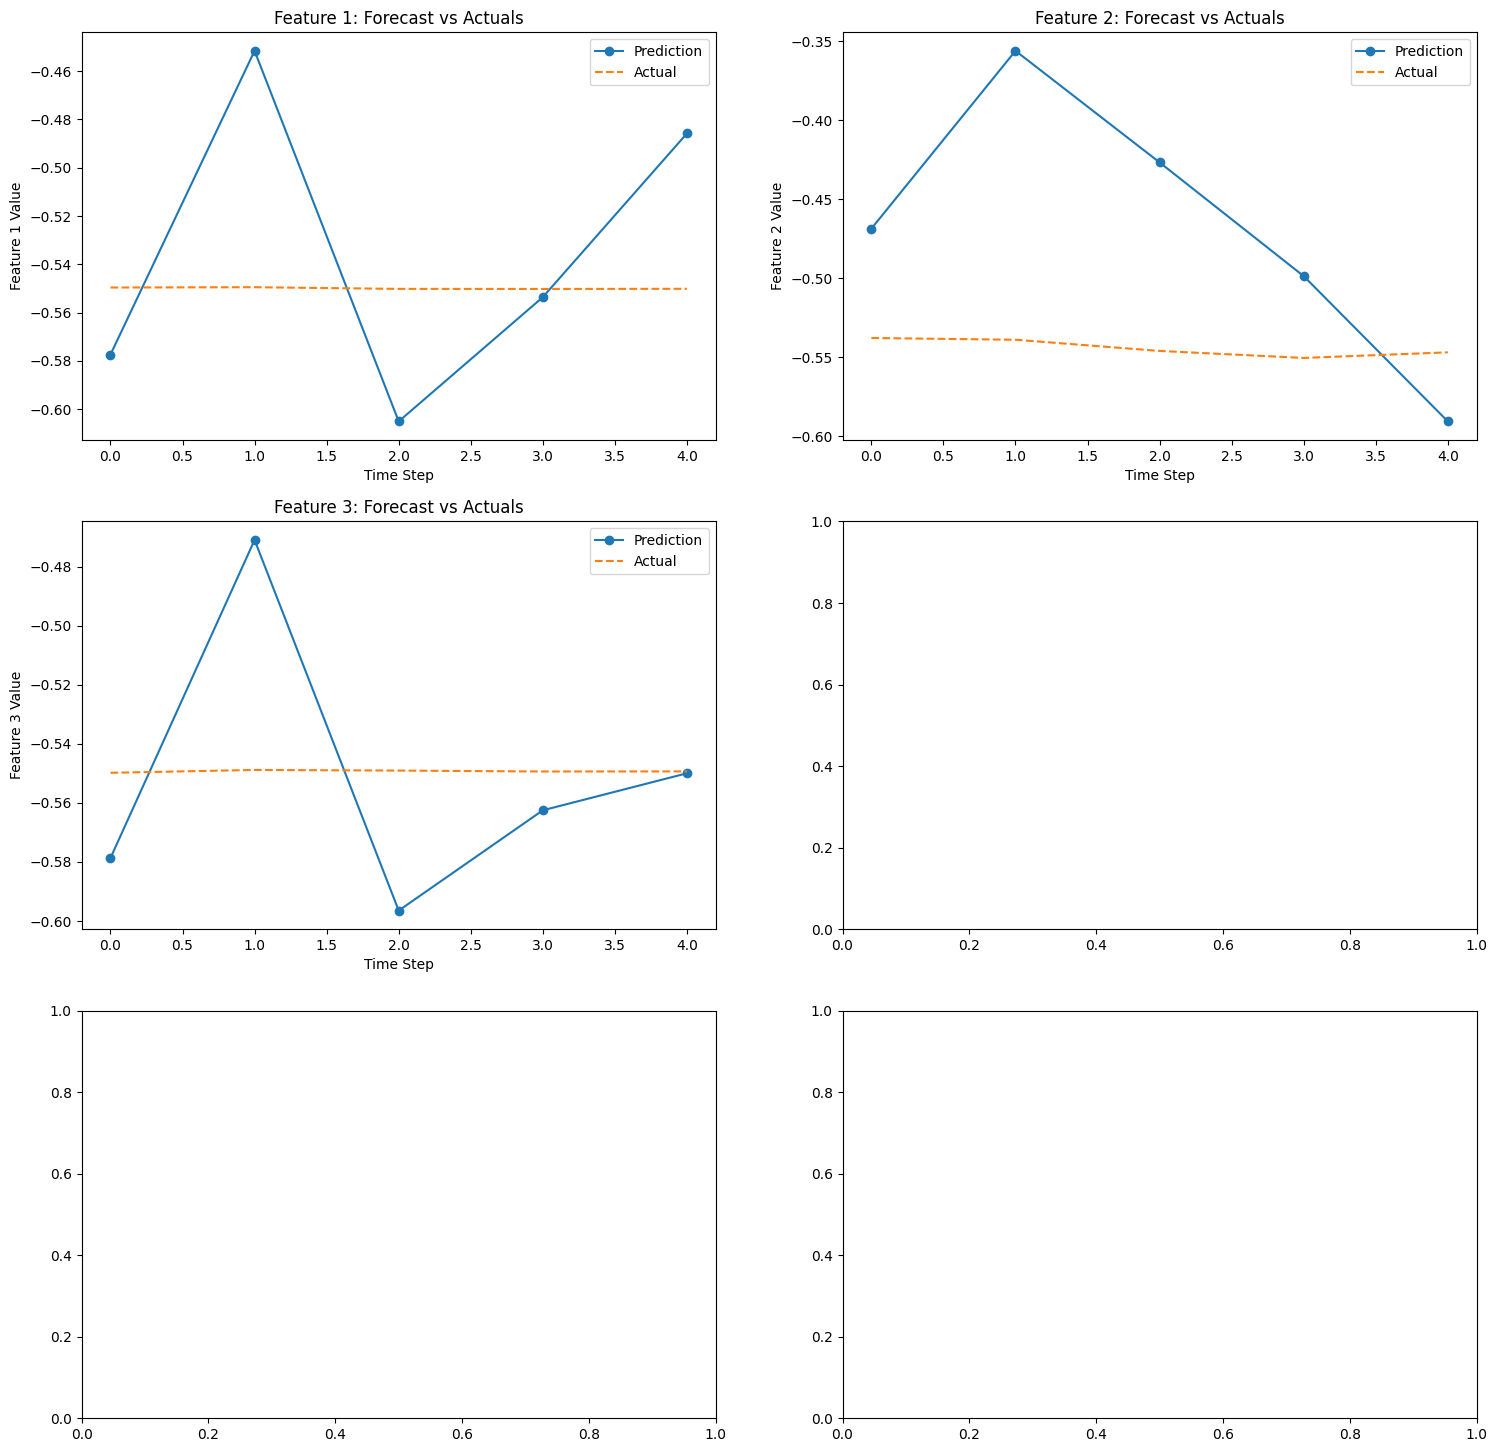

In [222]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming model, data_loader, and device are already defined and the model is trained

model.eval()  # Set the model to evaluation mode

# Fetch a batch of data
enc_input, dec_input, actuals = next(iter(data_loader))

# Move tensors to the same device as the model
enc_input, dec_input, actuals = enc_input.to(device), dec_input.to(device), actuals.to(device)

# Get predictions from the model
with torch.no_grad():
    predictions = model(enc_input, dec_input).cpu().numpy()

# Convert actuals to numpy
actuals = actuals.cpu().numpy()

# Determine the number of features (assuming features are the last dimension)
num_features = predictions.shape[0]
num_timesteps = predictions.shape[1]
num_rows = int(np.ceil(num_features / 3))
# Create subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(18, 6 * num_rows), squeeze=False)

# Generate time steps dynamically
time_steps = np.arange(num_timesteps)

# Plot predictions and actuals in different subplots
for i in range(num_features):
    # Determine the row and column to plot
    row = i // 2
    col = i % 2
    # Ensure that axs is indexed correctly when num_features is 1
    ax = axs[i] if num_features > 1 else axs

    # Plot for each feature
    axs[row, col].plot(time_steps, predictions[i, :], label='Prediction', marker='o')  # Example for first sample
    axs[row, col].plot(time_steps, actuals[i, :], label='Actual', linestyle='--')  # Example for first sample
    axs[row, col].set_xlabel('Time Step')
    axs[row, col].set_ylabel(f'Feature {i+1} Value')
    axs[row, col].legend()
    axs[row, col].set_title(f'Feature {i+1}: Forecast vs Actuals')

plt.tight_layout()
plt.show()


In [200]:
predictions.shape

(4, 3)